In [37]:
import os
import random
import shutil
import json
from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

import torchaudio
import torchaudio.transforms as transforms

import pytorch_lightning as pl
from config import Config

In [38]:
pl.seed_everything(100)

Seed set to 100


100

In [39]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device is", device)

The device is cuda


In [40]:
SAMPLE_RATE = 16000
N_MFCC = 20
FRAME_LENGTH_DURATION = 0.02
FRAME_SKIP_DURATION = 0.01
N_FFT = int(SAMPLE_RATE * FRAME_LENGTH_DURATION)
HOP_LENGTH = int(SAMPLE_RATE * FRAME_SKIP_DURATION)
print(N_FFT, HOP_LENGTH)

N_OUTPUT_CLASS = 2

320 160


In [41]:
audio, sr = librosa.load(r"E:\Desktop\StutterDetModel\data\clips\stuttering-clips\clips\WomenWhoStutter_108_19.wav", sr=SAMPLE_RATE)
print(sr)

16000


In [42]:
mfcc = librosa.feature.mfcc(
    y=audio,
    hop_length=HOP_LENGTH,
    n_fft=N_FFT,
    n_mfcc=N_MFCC,
    n_mels=30
)
mfcc.shape

(20, 301)

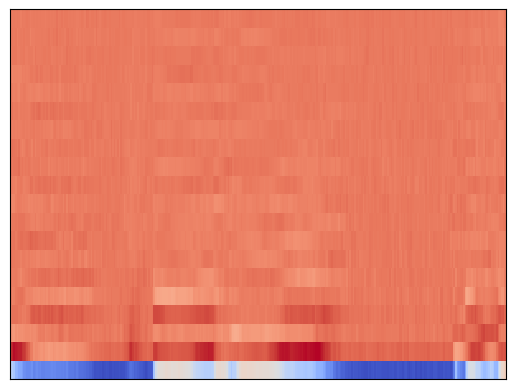

In [43]:
librosa.display.specshow(mfcc)

In [44]:
Audio(audio, rate=SAMPLE_RATE)

In [45]:
from config import Config

In [79]:
class StatisticalPooling(nn.Module):
    def __init__(self):
        super(StatisticalPooling, self).__init__()

    def forward(self, x):
        mean = torch.mean(x, dim=-1)
        std = torch.std(x, dim=-1)
        return torch.cat((mean, std), dim=-1)
    
class StutterNetHead(nn.Module):
    def __init__(
            self,
            context_setting=(5, 2), # (9, 4)
            hidden_layers=Config.HIDDEN_LAYERS
    ):
        super(StutterNetHead, self).__init__()
        self.hidden_layers = hidden_layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=Config.N_MFCC, 
                out_channels=hidden_layers[0],
                kernel_size=context_setting[0],
                stride=1,
                padding=context_setting[1],
                dilation=1
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[0])
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[0], 
                out_channels=hidden_layers[1],
                kernel_size=3,
                stride=1,
                padding=2,
                dilation=2
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[1])
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[1], 
                out_channels=hidden_layers[2],
                kernel_size=3,
                stride=1,
                padding=3,
                dilation=3
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[2])
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[2], 
                out_channels=hidden_layers[3],
                kernel_size=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[3])
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[3], 
                out_channels=hidden_layers[4],
                kernel_size=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[4])
        )
        self.bilstm = nn.LSTM(
            input_size=301,
            hidden_size=hidden_layers[5],
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.statspool = StatisticalPooling()
    
    def forward(self, input_data):
        out = self.conv1(input_data)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        hidden = (
            torch.zeros(2*2, out.size(0), self.hidden_layers[5]).requires_grad_(True).to("cuda"),
            torch.zeros(2*2, out.size(0), self.hidden_layers[5]).requires_grad_(True).to("cuda")
        )
        out, _ = self.bilstm(out, hidden)
        out = self.statspool(out)
        return out

In [87]:
model = StutterNetHead(context_setting=(9, 4))
model = model.to("cuda")

In [88]:
model(torch.rand(Config.BATCH_SIZE, 20, 301).to("cuda")).shape

torch.Size([128, 384])

In [59]:
NUM_FRAMES = 3 * 16000 / HOP_LENGTH
NUM_FRAMES

300.0

In [61]:
class StutterNetHead1(nn.Module):
    def __init__(
            self,
            hidden_layers=Config.HIDDEN_LAYERS
    ):
        super(StutterNetHead1, self).__init__()
        self.hidden_layers = hidden_layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=Config.N_MFCC, 
                out_channels=hidden_layers[0],
                kernel_size=5,
                stride=1,
                padding=2,
                dilation=1
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[0])
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[0], 
                out_channels=hidden_layers[1],
                kernel_size=3,
                stride=1,
                padding=2,
                dilation=2
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[1])
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[1], 
                out_channels=hidden_layers[2],
                kernel_size=3,
                stride=1,
                padding=3,
                dilation=3
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[2])
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[2], 
                out_channels=hidden_layers[3],
                kernel_size=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[3])
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[3], 
                out_channels=hidden_layers[4],
                kernel_size=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[4])
        )
        self.bilstm = nn.LSTM(
            input_size=301,
            hidden_size=hidden_layers[5],
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.statspool = StatisticalPooling()
    
    def forward(self, input_data):
        out = self.conv1(input_data)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        hidden = (
            torch.zeros(2*2, out.size(0), self.hidden_layers[5]).requires_grad_(True).to("cuda"),
            torch.zeros(2*2, out.size(0), self.hidden_layers[5]).requires_grad_(True).to("cuda")
        )
        out, _ = self.bilstm(out, hidden)
        out = self.statspool(out)
        return out

In [66]:
class StutterNetHead2(nn.Module):
    def __init__(
            self,
            hidden_layers=Config.HIDDEN_LAYERS
    ):
        super(StutterNetHead2, self).__init__()
        self.
        self.conv3 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[1], 
                out_channels=hidden_layers[2],
                kernel_size=3,
                stride=1,
                padding=3,
                dilation=3
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[2])
        )
        self.conv4 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[2], 
                out_channels=hidden_layers[3],
                kernel_size=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[3])
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(
                in_channels=hidden_layers[3], 
                out_channels=hidden_layers[4],
                kernel_size=1,
                stride=1,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[4])
        )
        self.bilstm = nn.LSTM(
            input_size=297,
            hidden_size=hidden_layers[5],
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.statspool = StatisticalPooling()
    
    def forward(self, input_data):
        out = self.conv1(input_data)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        hidden = (
            torch.zeros(2*2, out.size(0), self.hidden_layers[5]).requires_grad_(True).to("cuda"),
            torch.zeros(2*2, out.size(0), self.hidden_layers[5]).requires_grad_(True).to("cuda")
        )
        out, _ = self.bilstm(out, hidden)
        out = self.statspool(out)
        return out

In [78]:
hidden_layers = Config.HIDDEN_LAYERS
conv1 = nn.Sequential(
            nn.Conv1d(
                in_channels=Config.N_MFCC, 
                out_channels=hidden_layers[0],
                kernel_size=9,
                stride=1,
                padding=4,
                dilation=1
            ),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_layers[0])
        ).to("cuda")
conv1(x).shape

torch.Size([128, 64, 301])

In [67]:
sn_1 = StutterNetHead1().to("cuda")
sn_1().shape

torch.Size([128, 384])

In [68]:
sn_2 = StutterNetHead2().to("cuda")
sn_2(torch.rand(Config.BATCH_SIZE, 20, 301).to("cuda")).shape

torch.Size([128, 384])

In [89]:
x = torch.rand(Config.BATCH_SIZE, 20, 301).to("cuda")

torch.concatenate([sn_1(x), sn_2(x)], axis=-1).shape

torch.Size([128, 768])

In [15]:
# with open(Config.KAGGLE_KEY_PATH, "r") as f:
#     data = json.load(f)
#     os.environ["KAGGLE_USERNAME"] = data["username"]
#     os.environ["KAGGLE_KEY"] = data["key"]
#     del data
# if not os.path.exists(os.path.join(Config.NOISE_DATA_DIR, r"fold1")):
#     print("Noise Data is downloaded from kaggle")
#     import kaggle
#     kaggle.api.authenticate()
#     kaggle.api.dataset_download_files(
#         "chrisfilo/urbansound8k",
#         path=Config.NOISE_DATA_DIR,
#         unzip=True
#     )
#     for i in range(1, 11):
#         shutil.rmtree(os.path.join(Config.NOISE_DATA_DIR, f"fold{i}"))
#     print("Noise Data was downloaded!")

Data is downloaded from kaggle
Data was downloaded!


In [31]:
audios_path = os.path.join(Config.DATA_DIR, r"clips/stuttering-clips/clips")
audio_list = os.listdir(audios_path)
audio_path = os.path.join(audios_path, random.choice(audio_list))
print(audio_path)

E://Desktop//StutterDetModel//data\clips/stuttering-clips/clips\WomenWhoStutter_88_204.wav


In [32]:
noises_path = os.path.join(Config.NOISE_DATA_DIR, "fold1")
noise_list = os.listdir(noises_path)
noise_path = os.path.join(noises_path, random.choice(noise_list))
print(noise_path)

E://Desktop//StutterDetModel//noise_data\fold1\73277-9-0-0.wav


In [33]:
import numpy as np
from scipy.signal import convolve

# Load the audio file
audio_data, sr = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True, duration=3)
noise, sr = librosa.load(noise_path, sr=SAMPLE_RATE, mono=True, duration=3)

if len(noise) < len(audio_data):
    noise = np.pad(noise, (0, len(audio_data) - len(noise)))

# Normalize the noise to match the amplitude of the original audio
noise_normalized = noise * np.std(audio_data) / np.std(noise)

# Add noise to the audio
y_noisy = audio_data + 0.05 * noise_normalized

In [34]:
Audio(y_noisy, rate=SAMPLE_RATE)

In [35]:
Audio(audio_data, rate=SAMPLE_RATE)

In [36]:
Audio(noise, rate=SAMPLE_RATE)

In [5]:
from dataset import StutterDataset
sd = StutterDataset()

In [18]:
rand_index = random.randint(0, 12000)
Audio(sd[rand_index][0], rate=SAMPLE_RATE)